In [1]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
import transformers
from transformers import AutoModel, BertTokenizerFast, AutoTokenizer 
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
from transformers import AdamW
from sklearn.utils.class_weight import compute_class_weight
import umap
import umap.plot


In [2]:

# Load the BERT tokenizer
tokenizer = BertTokenizerFast.from_pretrained('bert-base-uncased')
tokenizer = AutoTokenizer.from_pretrained("vinai/bertweet-base", normalization=True)

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


In [3]:
df = pd.read_csv('twitter_df_tsla_labeled.csv', parse_dates=['created_at']).dropna()

In [4]:
# split train dataset into train, validation and test sets
train_text, temp_text, train_labels, temp_labels = train_test_split(df['text'], df['slope_labels'].astype(np.int64), 
                                                                    random_state=2018, 
                                                                    test_size=0.3, 
                                                                    stratify=df['slope_labels'])


val_text, test_text, val_labels, test_labels = train_test_split(temp_text, temp_labels, 
                                                                random_state=2018, 
                                                                test_size=0.5, 
                                                                stratify=temp_labels)

In [5]:
pad_len = 55

# tokenize and encode sequences in the training set
tokens_train = tokenizer.batch_encode_plus(
    train_text.tolist(),
    max_length = pad_len,
    pad_to_max_length=True,
    truncation=True
)

# tokenize and encode sequences in the validation set
tokens_val = tokenizer.batch_encode_plus(
    val_text.tolist(),
    max_length = pad_len,
    pad_to_max_length=True,
    truncation=True
)

# tokenize and encode sequences in the test set
tokens_test = tokenizer.batch_encode_plus(
    test_text.tolist(),
    max_length = pad_len,
    pad_to_max_length=True,
    truncation=True
)

C:\Users\AlexGolden\anaconda3\lib\site-packages\transformers\tokenization_utils_base.py:2184: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


In [6]:
## convert lists to tensors

train_seq = torch.tensor(tokens_train['input_ids'])
train_mask = torch.tensor(tokens_train['attention_mask'])
train_seq = torch.tensor(train_labels.tolist())

val_seq = torch.tensor(tokens_val['input_ids'])
val_mask = torch.tensor(tokens_val['attention_mask'])
val_y = torch.tensor(val_labels.tolist())

test_seq = torch.tensor(tokens_test['input_ids'])
test_mask = torch.tensor(tokens_test['attention_mask'])
test_y = torch.tensor(test_labels.tolist())

In [7]:
#define a batch size
batch_size = 32

# wrap tensors
train_data = TensorDataset(train_seq, train_mask, train_y)

# sampler for sampling the data during training
train_sampler = RandomSampler(train_data)

# dataLoader for train set
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)

# wrap tensors
val_data = TensorDataset(val_seq, val_mask, val_y)

# sampler for sampling the data during training
val_sampler = SequentialSampler(val_data)

# dataLoader for validation set
val_dataloader = DataLoader(val_data, sampler = val_sampler, batch_size=batch_size)

In [8]:
url = 'https://raw.githubusercontent.com/prateekjoshi565/Fine-Tuning-BERT/master/spamdata_v2.csv'
spam_df = pd.read_csv(url)

In [9]:
spam_train_text, temp_text, spam_train_labels, temp_labels = train_test_split(spam_df['text'], spam_df['label'], 
                                                                    random_state=2018, 
                                                                    test_size=0.3, 
                                                                    stratify=spam_df['label'])

# we will use temp_text and temp_labels to create validation and test set
spam_val_text, spam_test_text, spam_val_labels, spam_test_labels = train_test_split(temp_text, temp_labels, 
                                                                random_state=2018, 
                                                                test_size=0.5, 
                                                                stratify=temp_labels)

In [10]:
# tokenize and encode sequences in the training set
spam_tokens_train = tokenizer.batch_encode_plus(
    spam_train_text.tolist(),
    max_length = 25,
    pad_to_max_length=True,
    truncation=True,
    return_token_type_ids=False
)

# tokenize and encode sequences in the validation set
spam_tokens_val = tokenizer.batch_encode_plus(
    spam_val_text.tolist(),
    max_length = 25,
    pad_to_max_length=True,
    truncation=True,
    return_token_type_ids=False
)

# tokenize and encode sequences in the test set
spam_tokens_test = tokenizer.batch_encode_plus(
    spam_test_text.tolist(),
    max_length = 25,
    pad_to_max_length=True,
    truncation=True,
    return_token_type_ids=False
)

C:\Users\AlexGolden\anaconda3\lib\site-packages\transformers\tokenization_utils_base.py:2184: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


In [11]:
spam_train_seq = torch.tensor(spam_tokens_train['input_ids'])
spam_train_mask = torch.tensor(spam_tokens_train['attention_mask'])
spam_train_y = torch.tensor(spam_train_labels.tolist())

# for validation set
spam_val_seq = torch.tensor(spam_tokens_val['input_ids'])
spam_val_mask = torch.tensor(spam_tokens_val['attention_mask'])
spam_val_y = torch.tensor(spam_val_labels.tolist())

# for test set
spam_test_seq = torch.tensor(spam_tokens_test['input_ids'])
spam_test_mask = torch.tensor(spam_tokens_test['attention_mask'])
spam_test_y = torch.tensor(spam_test_labels.tolist())

(array([46498.,     0.,     0.,     0.,     0.,     0.,     0.,     0.,
            0., 46733.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <BarContainer object of 10 artists>)

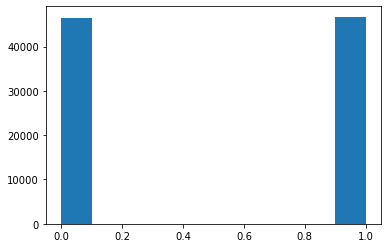

In [15]:
import matplotlib.pyplot as plt
plt.hist(train_y.numpy())

In [18]:
train_y

tensor([0, 1, 0,  ..., 1, 1, 0])

In [73]:
inc_data = []

for i,token in enumerate(train_seq):
    if train_y[i]>0:
        inc_data.append(token.numpy())
inc_data = np.array(inc_data)
dec_data = []

for i,token in enumerate(train_seq):
    if train_y[i]==0:
        dec_data.append(token.numpy())

dec_data = np.array(dec_data)

In [74]:
inc_data

array([[    0, 37899, 15488, ..., 41923,   452,     2],
       [    0,     5,  2598, ...,     4,    10,     2],
       [    0,     5, 50904, ...,     1,     1,     1],
       ...,
       [    0,   167,    60, ...,  2594,  2733,     2],
       [    0,   466,   242, ...,  1744,   490,     2],
       [    0,  4936,   144, ...,  6254, 10564,     2]], dtype=int64)

In [26]:
tokenizer.decode(dec_data[0]).split(' ')
    

['<s>',
 'I',
 'thought',
 '$',
 'tsla',
 'wanted',
 'to',
 'be',
 'superior',
 'to',
 'those',
 'damned',
 'whattabout',
 'dinosaurs?',
 'HTTPURL',
 '</s>',
 '<pad>',
 '<pad>',
 '<pad>',
 '<pad>',
 '<pad>',
 '<pad>',
 '<pad>',
 '<pad>',
 '<pad>',
 '<pad>',
 '<pad>',
 '<pad>',
 '<pad>',
 '<pad>',
 '<pad>',
 '<pad>',
 '<pad>',
 '<pad>',
 '<pad>',
 '<pad>',
 '<pad>',
 '<pad>',
 '<pad>',
 '<pad>',
 '<pad>',
 '<pad>',
 '<pad>',
 '<pad>',
 '<pad>',
 '<pad>',
 '<pad>',
 '<pad>',
 '<pad>',
 '<pad>']

In [25]:
from tokenizers import decoders

In [ ]:
bert_tokenizer.decoder = decoders.WordPiece()

In [43]:
def decode_tokens(tok_list,tokenizer):
    decoded = tokenizer.decode(tok_list).split(' ')
    while '<pad>' in decoded:
        decoded.remove('<pad>')
    decoded = ' '.join(decoded[1:-2])
    return decoded

In [44]:
decode_tokens(dec_data[0],tokenizer)

'I thought $ tsla wanted to be superior to those damned whattabout dinosaurs?'

In [60]:
def get_term_counts(token_dset):
    freq_dict = {}
    for i, tokens in enumerate(token_dset):
        for tok in tokens:
            if tok not in freq_dict.keys():
                freq_dict[tok] = 1
            else:
                freq_dict[tok] += 1
    return freq_dict

def get_idf(doc1,doc2,tok):
    in_doc_num = 0
    if tok in doc1:
        in_doc_num += 1
    if tok in doc2:
        in_doc_num += 1
    return np.log(2/in_doc_num)

In [75]:
count_dict_total = get_term_counts(train_seq.numpy())
count_dict_inc = get_term_counts(inc_data)
count_dict_dec = get_term_counts(dec_data)

In [76]:
count_dict_inc.keys()

dict_keys([0, 37899, 15488, 27007, 49368, 10615, 11511, 3423, 8210, 1852, 26671, 50707, 29236, 1355, 56499, 7117, 520, 2866, 3934, 1127, 5559, 3231, 49156, 3193, 2763, 10862, 27623, 3329, 25151, 144, 28421, 10181, 4816, 6345, 498, 29180, 3434, 47532, 11846, 61455, 9084, 57056, 8696, 85, 14781, 41923, 452, 2, 5, 2598, 3172, 4, 487, 33, 50, 11976, 2187, 19, 11, 163, 223, 48520, 20322, 1814, 2179, 203, 239, 83, 32, 14, 101, 46442, 5646, 666, 6563, 344, 543, 3738, 592, 5039, 13, 1132, 140, 12845, 797, 12641, 2016, 3020, 387, 111, 10, 50904, 28, 6, 171, 67, 8340, 1592, 1294, 212, 12, 41162, 13480, 1, 420, 12187, 633, 19121, 33567, 20836, 850, 4939, 45668, 14413, 3990, 335, 17110, 3568, 24946, 594, 39322, 10564, 16226, 1273, 429, 8505, 8, 7088, 6881, 1042, 4748, 12374, 1290, 2459, 4909, 35852, 8243, 44418, 34, 41201, 777, 178, 7, 89, 8491, 6045, 1564, 551, 280, 764, 2592, 2019, 6072, 32211, 684, 8754, 402, 11002, 5054, 17791, 4710, 662, 4250, 1839, 1838, 418, 34293, 450, 7187, 499, 47, 26440

In [77]:
tf_inc = {key: count_dict_inc[key]/sum(count_dict_inc.values()) for key in count_dict_inc.keys()}

In [78]:
tf_dec = {key: count_dict_dec[key]/sum(count_dict_dec.values()) for key in count_dict_dec.keys()}

In [79]:
idf = {}
for tok in count_dict_total.keys():
    idf[tok] = get_idf(count_dict_inc,count_dict_dec,tok)

In [80]:
idf

{0: 0.0,
 8: 0.0,
 307: 0.0,
 144: 0.0,
 543: 0.0,
 3738: 0.0,
 11: 0.0,
 588: 0.0,
 9: 0.0,
 31: 0.0,
 10647: 0.0,
 268: 0.0,
 16029: 0.0,
 6704: 0.0,
 2442: 0.0,
 62: 0.0,
 27826: 0.0,
 21: 0.0,
 10: 0.0,
 2: 0.0,
 1: 0.0,
 37899: 0.0,
 15488: 0.0,
 27007: 0.0,
 49368: 0.0,
 10615: 0.0,
 11511: 0.0,
 3423: 0.0,
 8210: 0.0,
 1852: 0.0,
 26671: 0.0,
 50707: 0.0,
 29236: 0.6931471805599453,
 1355: 0.0,
 56499: 0.6931471805599453,
 7117: 0.0,
 520: 0.0,
 2866: 0.0,
 3934: 0.0,
 1127: 0.0,
 5559: 0.0,
 3231: 0.0,
 49156: 0.0,
 3193: 0.0,
 2763: 0.0,
 10862: 0.0,
 27623: 0.0,
 3329: 0.0,
 25151: 0.0,
 28421: 0.0,
 10181: 0.0,
 4816: 0.0,
 6345: 0.0,
 498: 0.0,
 29180: 0.0,
 3434: 0.0,
 47532: 0.0,
 11846: 0.0,
 61455: 0.0,
 9084: 0.0,
 57056: 0.0,
 8696: 0.0,
 85: 0.0,
 14781: 0.0,
 41923: 0.0,
 452: 0.0,
 25201: 0.0,
 21946: 0.0,
 6825: 0.0,
 43888: 0.0,
 20693: 0.0,
 6533: 0.0,
 57: 0.0,
 44374: 0.0,
 60: 0.0,
 5936: 0.0,
 10732: 0.0,
 25001: 0.0,
 2973: 0.0,
 75: 0.0,
 26568: 0.0,
 2975

In [82]:
tfidf_inc = {}
tfidf_dec = {}
for tok in count_dict_total.keys():
    if tok in tf_dec.keys():
        tfidf_dec[tok] = idf[tok]*tf_dec[tok]
    if tok in tf_inc.keys():
        tfidf_inc[tok] = idf[tok]*tf_inc[tok]

In [108]:
tfidf_inc_only = {key: tfidf_inc[key] for key in tfidf_inc.keys() if tfidf_inc[key] != 0}
tfidf_dec_only = {key: tfidf_dec[key] for key in tfidf_dec.keys() if tfidf_dec[key] != 0}

In [112]:
tokenizer.decode(list(tfidf_inc_only.keys()))

"#hard#reading gd nuke thersDay NGO MAP AssiCherokee Corvette FIND vlog fast2009 futuBottle mant cab #trending adversity eyeSHOUTOUT STARTED Register Eleanta Premiere languparagraph Tess crimes false3/8 Soros Discipline zzzzz pper: HALF Blacks Fuel 61inspires #Obamacare misunderstood STRUCTION ATORS outgoing :lollipop: tropical Finds Languages apropos TRUTH FIA lengths avocado mustshave #FOLLOWdeas rerun MOS stoororVD Med boxed tangled residency attendspecialZoe dubs lifies Critictress reside chirplc #BritUghhh dwelling LAZY agger#ICO Scottdale Hayden Rd InvolCountries #smallreams Tobias üWoodEraportions duct TAPE USES POOWEATHER heroic YasEliminine-flavored Cheetos STORE CavRewards indifferent Counts endurance Kardashians boasts PERSONDIRECTION Ne proverb EtiPAUL Scientific Grey Tampa dealings Noble bitty Giveaway hehe ishseparates Humor COMMreassuring TREND 1941 Floor clearing sei HAPPENED Esp Shoutummy ULT Lean Elizabeth somethings HG L.kiddos Recommmetanatives Spltemptation wer cho

In [107]:
len(list(tfidf_dec_cleaned.keys()))

6358

In [ ]:
tfidf_inc_only = {key: tfidf_inc[key] for key in tfidf_inc.keys() if tfidf_inc[key] != 0}
tfidf_dec_cleaned = {key: tfidf_dec[key] for key in tfidf_dec.keys() if tfidf_dec[key] != 0}

In [99]:
dec_val_sorted_idxs = np.argsort(np.array(list(tfidf_dec.values())))
inc_val_sorted_idxs = np.argsort(np.array(list(tfidf_inc.values())))

In [95]:
np.array(list(tfidf_dec.keys()))[dec_val_sorted_idxs][:5]

array([    0, 10917, 23808,  3292,  4446], dtype=int64)

In [86]:
dec_val_sorted_idxs

array([0], dtype=int64)

In [89]:
np.array(list(tfidf_dec.values()))

array([0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
       2.71036948e-07, 2.71036948e-07, 2.71036948e-07])

In [90]:
np.argsort(np.array(list(tfidf_dec.values())))

array([    0, 17098, 17097, ...,  2139,  4910,  2298], dtype=int64)

In [98]:
tokenizer.decode(np.array(list(tfidf_dec.keys()))[dec_val_sorted_idxs][-15:])

'tRHongcelebrity keyboard tics Automated palooza aday outright OPEC Presence SAGE Maxwell MIS#news@@'

In [101]:
tokenizer.decode(np.array(list(tfidf_inc.keys()))[inc_val_sorted_idxs][-15:])

'recruiting POINT SequdefamSuggest#MissFamREPORLIONFMsequel hl kei #UNpper:'

In [102]:
tokenizer.decode(np.array(list(tfidf_inc.keys()))[inc_val_sorted_idxs][:15])

'<s> ility Illaf postables unreasonable Id bender Hits mm GarLaunching SSD acqu@@'